In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import numpy as np

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / 'src').is_dir():
    PROJECT_ROOT = PROJECT_ROOT.parent
SRC_ROOT = PROJECT_ROOT / 'src'
DATA_ROOT = PROJECT_ROOT / 'data' / 'processed'

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f'Using project root: {PROJECT_ROOT}')
print(f'Data directory: {DATA_ROOT}')

Using project root: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning
Data directory: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\data\processed


In [2]:
from src.Bayesian_state.utils.load_config import MODEL_STRUCT
from src.Bayesian_state.utils.state_grid_optimizer import StateModelGridOptimizer
from src.Bayesian_state.utils.state_amr_optimizer import StateModelAMROptimizer

model_choice = 'pm_model'
engine_config = MODEL_STRUCT.get(model_choice)
if engine_config is None:
    raise ValueError(f'Model {model_choice} not found.')

grid_opt = StateModelGridOptimizer(engine_config=engine_config, processed_data_dir=DATA_ROOT, n_jobs=12)

print(f'Loaded configuration for: {model_choice}')

INFO:cat-learning:logger is running normally.


D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\logs\Run_20260106_201615.log
{'base_model': {'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {}}}, 'agenda': ['likelihood_mod', '__self__']}, 'default_model': {'modules': {}, 'agenda': ['__self__']}, 'm_model': {'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 15.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.8, 'gamma': 0.8}}}, 'agenda': ['likelihood_mod', 'memory_mod']}, 'pmh_model': {'modules': {'perception_mod': {'class': 'src.Bayesian_state.problems.modules.perception.PerceptionModule'}, 'hypo_transitions_mod': {'class': 'src.Bayesian_state.problems.modules.hypo_transitions.DynamicHypothesisModule', 'kwargs': {'strategies': 'original_strategies_b', 'init_num': 8}}, 'likelihood_mod': {'class': 'src.Bayesi

In [3]:
data_path = DATA_ROOT / 'Task2_processed.csv'
grid_opt.prepare_data(data_path)
print(f'Data loaded: {data_path}')

Data loaded: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\data\processed\Task2_processed.csv


In [4]:
subject_id = 2
window_size = 16
stop_at = 1.  # use a fraction to keep runtime manageable
param_grid = {
    'gamma': [0.1, 0.4, 0.7, 0.9, 0.95],
    'w0': [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.9],
    'beta': [8.0, 10.0],
}

grid_repeats = 4
refit_repeats = 16
combos = int(np.prod([len(v) for v in param_grid.values()]))
budget = combos
print(f'Grid combos: {combos}, budgeted evals per AMR: {budget}')

Grid combos: 70, budgeted evals per AMR: 70


In [5]:
amr_kwargs = {
    'max_evals': max(1, budget),  
    'coarse_grid_per_dim': 3,
    'split_factor': 2,
    'refine_top_k': 3,
}

print('Running AMR optimizer...')
amr_opt = StateModelAMROptimizer(engine_config=engine_config, processed_data_dir=DATA_ROOT, amr_kwargs=amr_kwargs, n_jobs=grid_repeats)
amr_opt.prepare_data(data_path)
amr_results = amr_opt.optimize_subject(
    subject_id=subject_id,
    param_grid=param_grid,
    n_repeats=grid_repeats,
    refit_repeats=refit_repeats,
    window_size=window_size,
    stop_at=stop_at,
    keep_logs=False,
)
print('AMR search done.')

Running AMR optimizer...


INFO:cat-learning:Refitting best params for subject 2 with 16 repeats.


AMR search done.


In [6]:
print('Running grid optimizer...')
grid_results = grid_opt.optimize_subject(
    subject_id=subject_id,
    param_grid=param_grid,
    n_repeats=grid_repeats,
    refit_repeats=refit_repeats,
    window_size=window_size,
    stop_at=stop_at,
    keep_logs=False,
)
print('Grid search done.')

INFO:cat-learning:Optimizing subject 2: 70 combos * 4 repeats = 280 tasks


Running grid optimizer...


Sub 2 Grid Search: 100%|██████████| 280/280 [02:32<00:00,  1.84it/s]
INFO:cat-learning:Refitting best params for subject 2 with 16 repeats.
Sub 2 Refit: 100%|██████████| 16/16 [00:00<00:00, 15883.75it/s]


Grid search done.


In [7]:
from pprint import pprint

print('--- Grid Best ---')
pprint(grid_results['best'].params)
print(f"Grid mean error: {grid_results['best'].mean_error:.6f}")

print('--- AMR Best ---')
pprint(amr_results['best'].params)
print(f"AMR mean error:  {amr_results['best'].mean_error:.6f}")

delta = amr_results['best'].mean_error - grid_results['best'].mean_error
print(f'Delta (AMR - Grid): {delta:.6f}')

if abs(delta) < 1e-3:
    print('✅ AMR closely matches grid result on this dataset.')
else:
    print('⚠️ Differences detected; consider increasing budget or repeats.')

--- Grid Best ---
{'beta': 10.0, 'gamma': 0.1, 'w0': 0.01}
Grid mean error: 0.104436
--- AMR Best ---
{'beta': 10.0, 'gamma': 0.1, 'w0': 0.010000000000000009}
AMR mean error:  0.104324
Delta (AMR - Grid): -0.000112
✅ AMR closely matches grid result on this dataset.



Top 5 Parameter Combinations:
    beta  gamma    w0  mean_error  std_error
1   10.0    0.1  0.01    0.104436   0.000375
15  10.0    0.4  0.01    0.105758   0.000270
3   10.0    0.1  0.02    0.110313   0.000308
2    8.0    0.1  0.02    0.112845   0.000237
17  10.0    0.4  0.02    0.112891   0.000267


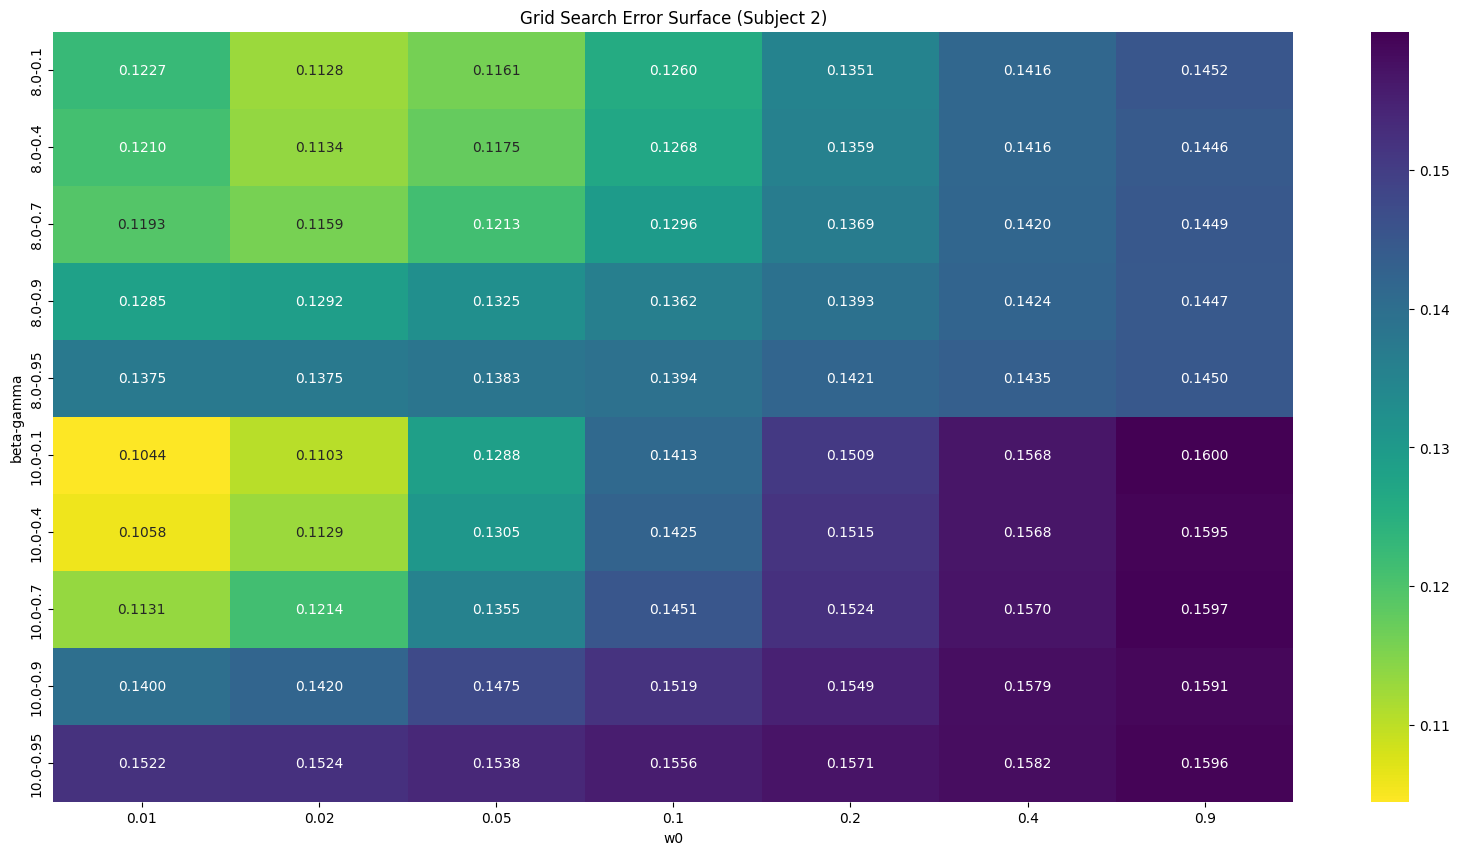

In [8]:
# 画出网格结果
# Visualization (Optional)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

grid_data = []
for res in grid_results['grid']:
    row = res.params.copy()
    row['mean_error'] = res.mean_error
    row['std_error'] = res.std_error
    grid_data.append(row)

df_results = pd.DataFrame(grid_data)
df_results = df_results.sort_values('mean_error')

print("\nTop 5 Parameter Combinations:")
print(df_results.head(5))
# Pivot for heatmap (assuming 2D grid: gamma vs w0)
if "gamma" in df_results.columns and "w0" in df_results.columns:
    pivot_table = df_results.pivot(index=["beta", "gamma"], columns="w0", values="mean_error")
    
    plt.figure(figsize=(20, 10))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis_r")
    plt.title(f"Grid Search Error Surface (Subject {subject_id})")
    plt.show()
